## Synthetic Ensemble Generation

This notebook is used to test some capabilities of bm_methods with synthetic ensembles. This will prove useful for setting 'bimodal criteria' and understanding the expected TP/FP rates (as a function of ensemble size) with known distributions

In [92]:
# import packages

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns
import cython_routines.bm_methods as bm
from scipy import integrate, stats, optimize
from sklearn.mixture import GaussianMixture


def built_bim(X, return_D=False):
    model = GaussianMixture(2).fit(X.reshape(-1,1))
    m1,m2 = model.means_.flatten()
    s1,s2 = (model.covariances_**0.5).flatten()
#     #ashmansD
#     if return_D:
#         m1,m2 = model.means_.flatten()
#         s1,s2 = (model.covariances_**0.5).flatten()
#         D= 2**0.5 * np.abs(m1-m2)/(s1**2+s2**2)**0.5
#         print(s1,s2)
#         #D = (m2-m1)/(2*(s1+s2))
#         #{\displaystyle |\mu _{1}-\mu _{2}|\leq 2\min(\sigma _{1},\sigma _{2}).}
        
#         return model,D
    
    return m1,s1,m2,s2,model.weights_, 2**0.5 * np.abs(m1-m2)/(s1**2+s2**2)**0.5>2

def scotts_factor(ens_size):
    """
    by default kde calculates bw using scotts factor:
    n** (-1/(d+4))
    when n = length of data and d is num of dimension (=1 for us)
    """
    return ens_size**(-1./(1+4))
    
    

# explore member FP(member requirement,delta) phase space

In [95]:
n = 5000 #number of ensembles to be generated
ens_size = 50 #ensemble size

deltas = np.arange(1.8, 6, 0.1) #separation of two modes
mem_conditions = range(1,ens_size//2+1,2) #minimum number of members required
bms = np.zeros((len(deltas),len(mem_conditions), n))

for jj,d in enumerate(tqdm(deltas)):
    w=0.5
    m1=-d/2.; s1=1
    m2= d/2.; s2=1 
    #generate the 'true dist'
    true_dist = np.sort(np.append(np.random.normal(m1,s1,int(   w *1e6)),
                                  np.random.normal(m2,s2,int((1-w)*1e6)) ))

    ens = np.random.choice(true_dist, size = (n, ens_size), replace=True) #sample ens from true dist
    bw =  scotts_factor(ens_size)*np.std(ens,axis=-1) #scotts rule rule for bw
    
    GMM = built_bim(true_dist)
    print(GMM)
    for qq,e in enumerate(ens):

        roots = bm.root_finding(e, bw = bw[qq])

        Ms= roots[::2]
        ms= roots[1::2]
 
        if len(Ms)==2: #condition 1 is two maxima
            bin_ens = np.where(e<ms[0],0,1) # create binary ensemble
            bin_ens_size = sum(bin_ens)
            for ii,mem_cond in enumerate(mem_conditions): # condition 2 is number of members in each mode
                if (mem_cond<=bin_ens_size<=(ens_size-mem_cond)):
                    bms[jj,ii,qq] = True


  0%|                                                    | 0/42 [00:00<?, ?it/s]

(0.9479893689495856, 0.951836314483841, -0.9592273215255495, 0.9480109141411746, array([0.50341239, 0.49658761]), True)


  2%|█                                           | 1/42 [00:03<02:15,  3.30s/it]

(0.986633902053743, 0.9594501670823834, -1.0001564292355873, 0.9549016637064046, array([0.50303816, 0.49696184]), True)


  5%|██                                          | 2/42 [00:06<02:08,  3.22s/it]

(-1.0285764173516148, 0.9673180421868407, 1.036606786917585, 0.9640705343661178, array([0.50218294, 0.49781706]), True)


  7%|███▏                                        | 3/42 [00:09<02:05,  3.21s/it]

(-1.0705192653985787, 0.975830454929115, 1.0781747216140272, 0.9713980516489242, array([0.50167603, 0.49832397]), True)


 10%|████▏                                       | 4/42 [00:13<02:07,  3.36s/it]


KeyboardInterrupt: 

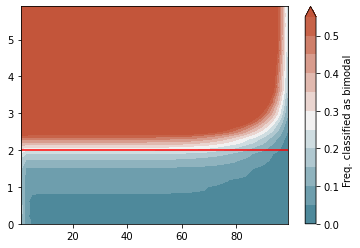

In [77]:
cm = sns.diverging_palette(220, 20, as_cmap=True)
cf=plt.contourf(mem_conditions,deltas, bms.mean(axis=-1), extend='max', cmap = cm,
                levels=np.arange(0,0.6,0.05))
plt.axhline(2., color = 'r')
#plt.xlim(10,20)
plt.colorbar(cf, label = 'Freq. classified as bimodal')

# Dip Testing

In [ ]:
n = 5000 #number of ensembles to be generated
ens_size = 50 #ensemble size

deltas = np.arange(0.1, 6, 0.1) #separation of two modes
dip_conditions = np.arange(1.01,2.,0.05)#strength of dip required #p(max)/p(min)
bms = np.zeros((len(deltas),len(dip_conditions), n))

for jj,d in enumerate(tqdm(deltas)):
    w=0.5
    m1=-d/2.; s1=1
    m2= d/2.; s2=1 
    
    #generate the 'true dist'
    true_dist = np.sort(np.append(np.random.normal(m1,s1,int(   w *1e6)),
                                  np.random.normal(m2,s2,int((1-w)*1e6)) ))

    ens = np.random.choice(true_dist, size = (n, ens_size), replace=True) #sample ens from true dist
    bw =  scotts_factor(ens_size)*np.std(ens,axis=-1) #scotts rule rule for bw
    #TODO: still find number of roots of 'true' dist
    
    for qq,e in enumerate(ens):

        roots = bm.root_finding(e, bw = bw[qq])

        Ms= roots[::2]
        ms= roots[1::2]
 
        if len(Ms)==2: #condition 1 is two maxima
            bin_ens = np.where(e<ms[0],0,1) # create binary ensemble
            bin_ens_size = sum(bin_ens)
            for ii,mem_cond in enumerate(mem_conditions): # condition 2 is number of members in each mode
                if (mem_cond<=bin_ens_size<=(ens_size-mem_cond)):
                    bms[jj,ii,qq] = True


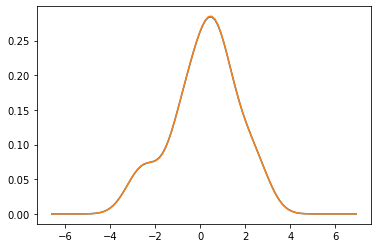

In [22]:
q = np.linspace(true_dist[0]-1,true_dist[-1]+1, 100)
kde = stats.gaussian_kde(e)
manualkde = [bm.continuous_pdf(x, e, bw) for x in q]
plt.plot(q, kde(q))
plt.plot(q,manualkde)
plt.show()

In [19]:
e

array([ 2.33286103,  0.75106816, -0.16524378, -2.44846098, -2.76169461,
        0.43862155, -2.29848133, -1.02367732, -2.09022098,  0.90280847,
        0.25412061,  0.98871348, -0.71934961,  1.45681216, -1.10282657,
       -0.55534837, -0.01131381, -1.01562533,  0.42838104,  0.28357899,
        0.77930061,  0.59377495,  1.05160883, -0.05845846,  2.62816496,
        0.42774024,  0.66653694,  2.08273764,  0.8819201 ,  1.95991516,
       -0.56750851,  0.26227052,  1.28292173,  0.54088019, -0.86074915,
        1.9185104 , -0.06636634,  0.2934119 ,  1.21529363, -2.59800729,
       -3.04856639,  0.0238696 ,  2.66986411,  1.40940091,  0.66836193,
       -0.57581757,  1.47186436, -1.11193087,  2.61125608, -0.33577862])